In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re #Regular Expressions
import string #importing string functions
import nltk
import warnings
from sklearn import tree
from sklearn import metrics #imports metrics model to check for accuracy
warnings.filterwarnings('ignore')
from nltk.stem.porter import PorterStemmer

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc

### **Read the data**

In [ ]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


In [ ]:
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [ ]:
#rename columns
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})

In [ ]:
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (23486, 2)


,Recommended,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


## **delete duplicates**

In [ ]:
#delete duplicates rows
print("Before dropping text_df: ",text_df.shape)
text_df.drop_duplicates(inplace = True)
print("After dropping text_df: ",text_df.shape)

Before dropping text_df:  (23486, 2)
After dropping text_df:  (19673, 2)


In [ ]:
text_df.head()

,Recommended,Review
0,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...


## **remove missing values**

In [ ]:
#detect missing values in datafarme
text_df.Review.isna().sum()

2

In [ ]:

#drop the null values
text_df.dropna(inplace=True)
text_df.head()
print("After dropping NaN text_df: ",text_df.shape)

After dropping NaN text_df:  (19671, 2)


In [ ]:
text_df['Recommended'].value_counts()

1    16096
0     3575
Name: Recommended, dtype: int64

In [ ]:
#plot a tree map to see th top 200 freq used before data cleaning
import plotly.express as px
FreqOfWords = df['Review Text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (Before Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

### **Upsampling**

In [ ]:
from sklearn.utils import resample

#create two different dataframe of majority and minority class
df_majority = text_df[(text_df['Recommended']==1)]
df_minority = text_df[(text_df['Recommended']==0)]

# upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,    # sample with replacement
                                 n_samples=15539 , # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

## **Data preprocessing**

In [ ]:
#removes pattern in the input text
#re.findall use to find all patterns in the text
# re.sub uses to  substitue each pattern that found in the text and replace it with empty string
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
        input_txt = re.sub(r"n't", "not", word)
    return input_txt


In [ ]:
#\w means [a to Z] and umbers ftom [0-9]
#and this code means to remove any word after @
df_upsampled["Cleaned_Review"] = np.vectorize(remove_pattern)(df_upsampled["Review"], "@[\w]*")
df_upsampled.head()

,Recommended,Review,Cleaned_Review
20700,0,Very large; lace is kinda coarse Thought i'd l...,Very large; lace is kinda coarse Thought i'd l...
23020,0,Way too much fabric I wanted to love this jump...,Way too much fabric I wanted to love this jump...
5625,0,So surprised by the poor quality I loved the l...,So surprised by the poor quality I loved the l...
8695,0,"Runs large I so wanted to love this tank, and ...","Runs large I so wanted to love this tank, and ..."
7689,0,"If you have a chest, beware I got this top in ...","If you have a chest, beware I got this top in ..."


In [ ]:
#Removing short words (words with length less than 3)
#The lambda function is splitting each review into individual words and then only keeping words that have a length greater than 3 characters and then join these word by putting a space between them
df_upsampled["Cleaned_Review"] = df_upsampled["Cleaned_Review"].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df_upsampled.head()

,Recommended,Review,Cleaned_Review
20700,0,Very large; lace is kinda coarse Thought i'd l...,Very large; lace kinda coarse Thought love thi...
23020,0,Way too much fabric I wanted to love this jump...,much fabric wanted love this jumpsuit. looks a...
5625,0,So surprised by the poor quality I loved the l...,surprised poor quality loved look this sweater...
8695,0,"Runs large I so wanted to love this tank, and ...","Runs large wanted love this tank, excited mail..."
7689,0,"If you have a chest, beware I got this top in ...","have chest, beware this typical size medium wa..."


## **tokenization**

In [ ]:
#split every review into individual words
df_upsampled["tokenized_review"] = df_upsampled["Cleaned_Review"].apply(lambda x: x.split())
df_upsampled["tokenized_review"].head()

20700    [Very, large;, lace, kinda, coarse, Thought, l...
23020    [much, fabric, wanted, love, this, jumpsuit., ...
5625     [surprised, poor, quality, loved, look, this, ...
8695     [Runs, large, wanted, love, this, tank,, excit...
7689     [have, chest,, beware, this, typical, size, me...
Name: tokenized_review, dtype: object

In [ ]:
#plot a tree map to see th top 200 freq used after tokenization
import plotly.express as px
FreqOfWords = df_upsampled["Cleaned_Review"].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (after tokenization)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

### **Text Mainpulation**

In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words=stopwords.words("english")
new_stopping_words = stop_words[:len(stop_words)-36]
new_stopping_words.remove("not")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#replace every n't with not
#replace every not alphanumeric character with space
def remove_punc(df):
    new_text= re.sub("n't",' not', df)
    new_text= re.sub('[^\w\s]','', df)
    return new_text

In [ ]:
# processed_text=remove_punc(str(df["Review Text"]))
# processed_text
#call the method before
processed_text=remove_punc(str(df_upsampled["Cleaned_Review"]))
processed_text

'20700    Very large lace kinda coarse Thought love thi\n23020    much fabric wanted love this jumpsuit looks a\n5625     surprised poor quality loved look this sweater\n8695     Runs large wanted love this tank excited mail\n7689     have chest beware this typical size medium wa\n                                                       \n23479    What piece wasnt sure about ordering this sk\n23481    Great dress many occasions very happy snag thi\n23482    Wish made cotton reminds maternity clothes so\n23484    Very cute dress perfect summer parties bought\n23485    Please make more like this one This dress lov\nName Cleaned_Review Length 31635 dtype object'

### **Tokenization**

In [ ]:
#split every review to words
def tokenizze(df):
    newdata= word_tokenize(df)
    return newdata

In [ ]:
#call the method before and make all characters in lowercase
tokenized_data=tokenizze(processed_text.lower())
tokenized_data

['20700',
 'very',
 'large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'thi',
 '23020',
 'much',
 'fabric',
 'wanted',
 'love',
 'this',
 'jumpsuit',
 'looks',
 'a',
 '5625',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'this',
 'sweater',
 '8695',
 'runs',
 'large',
 'wanted',
 'love',
 'this',
 'tank',
 'excited',
 'mail',
 '7689',
 'have',
 'chest',
 'beware',
 'this',
 'typical',
 'size',
 'medium',
 'wa',
 '23479',
 'what',
 'piece',
 'wasnt',
 'sure',
 'about',
 'ordering',
 'this',
 'sk',
 '23481',
 'great',
 'dress',
 'many',
 'occasions',
 'very',
 'happy',
 'snag',
 'thi',
 '23482',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'so',
 '23484',
 'very',
 'cute',
 'dress',
 'perfect',
 'summer',
 'parties',
 'bought',
 '23485',
 'please',
 'make',
 'more',
 'like',
 'this',
 'one',
 'this',
 'dress',
 'lov',
 'name',
 'cleaned_review',
 'length',
 '31635',
 'dtype',
 'object']

In [ ]:
# its a function to remove all numeric data by checking every character using isalpha()
def remove_num(df):
    text_without_num=[w for w in df if w.isalpha()]
    return text_without_num

In [ ]:
textwithoutnum= remove_num(tokenized_data)
textwithoutnum

['very',
 'large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'thi',
 'much',
 'fabric',
 'wanted',
 'love',
 'this',
 'jumpsuit',
 'looks',
 'a',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'this',
 'sweater',
 'runs',
 'large',
 'wanted',
 'love',
 'this',
 'tank',
 'excited',
 'mail',
 'have',
 'chest',
 'beware',
 'this',
 'typical',
 'size',
 'medium',
 'wa',
 'what',
 'piece',
 'wasnt',
 'sure',
 'about',
 'ordering',
 'this',
 'sk',
 'great',
 'dress',
 'many',
 'occasions',
 'very',
 'happy',
 'snag',
 'thi',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'so',
 'very',
 'cute',
 'dress',
 'perfect',
 'summer',
 'parties',
 'bought',
 'please',
 'make',
 'more',
 'like',
 'this',
 'one',
 'this',
 'dress',
 'lov',
 'name',
 'length',
 'dtype',
 'object']

### **Stemming and lemmatization**

In [ ]:
from nltk.stem import WordNetLemmatizer

def stemming_lemmatizing(tokens):
  stemmer = PorterStemmer()
  lemmatizer = WordNetLemmatizer()
  # Apply lemmatization and stemming on each tokens
  stemmed_tokens = [stemmer.stem(token) for token in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  return lemmatized_tokens



In [ ]:
nltk.download('wordnet')
data = stemming_lemmatizing(textwithoutnum)
data

[nltk_data] Downloading package wordnet to /root/nltk_data...


['very',
 'large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'thi',
 'much',
 'fabric',
 'wanted',
 'love',
 'this',
 'jumpsuit',
 'look',
 'a',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'this',
 'sweater',
 'run',
 'large',
 'wanted',
 'love',
 'this',
 'tank',
 'excited',
 'mail',
 'have',
 'chest',
 'beware',
 'this',
 'typical',
 'size',
 'medium',
 'wa',
 'what',
 'piece',
 'wasnt',
 'sure',
 'about',
 'ordering',
 'this',
 'sk',
 'great',
 'dress',
 'many',
 'occasion',
 'very',
 'happy',
 'snag',
 'thi',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'so',
 'very',
 'cute',
 'dress',
 'perfect',
 'summer',
 'party',
 'bought',
 'please',
 'make',
 'more',
 'like',
 'this',
 'one',
 'this',
 'dress',
 'lov',
 'name',
 'length',
 'dtype',
 'object']

### **remove stop words**

In [ ]:
def remove_stops(df):

    newdata=[t for t in df if t not in new_stopping_words]
    return newdata

In [ ]:
final_data=remove_stops(data)
final_data

['large',
 'lace',
 'kinda',
 'coarse',
 'thought',
 'love',
 'thi',
 'much',
 'fabric',
 'wanted',
 'love',
 'jumpsuit',
 'look',
 'surprised',
 'poor',
 'quality',
 'loved',
 'look',
 'sweater',
 'run',
 'large',
 'wanted',
 'love',
 'tank',
 'excited',
 'mail',
 'chest',
 'beware',
 'typical',
 'size',
 'medium',
 'wa',
 'piece',
 'wasnt',
 'sure',
 'ordering',
 'sk',
 'great',
 'dress',
 'many',
 'occasion',
 'happy',
 'snag',
 'thi',
 'wish',
 'made',
 'cotton',
 'reminds',
 'maternity',
 'clothes',
 'cute',
 'dress',
 'perfect',
 'summer',
 'party',
 'bought',
 'please',
 'make',
 'like',
 'one',
 'dress',
 'lov',
 'name',
 'length',
 'dtype',
 'object']

In [ ]:
joined_data=" ".join(final_data)
joined_data

'large lace kinda coarse thought love thi much fabric wanted love jumpsuit look surprised poor quality loved look sweater run large wanted love tank excited mail chest beware typical size medium wa piece wasnt sure ordering sk great dress many occasion happy snag thi wish made cotton reminds maternity clothes cute dress perfect summer party bought please make like one dress lov name length dtype object'

### **N-gram**

In [ ]:
from nltk.util import ngrams
#Define the n-gram range

n = 2

# Generate n-grams from the words
n_grams = list(ngrams(final_data, n))
n_grams


[('large', 'lace'),
 ('lace', 'kinda'),
 ('kinda', 'coarse'),
 ('coarse', 'thought'),
 ('thought', 'love'),
 ('love', 'thi'),
 ('thi', 'much'),
 ('much', 'fabric'),
 ('fabric', 'wanted'),
 ('wanted', 'love'),
 ('love', 'jumpsuit'),
 ('jumpsuit', 'look'),
 ('look', 'surprised'),
 ('surprised', 'poor'),
 ('poor', 'quality'),
 ('quality', 'loved'),
 ('loved', 'look'),
 ('look', 'sweater'),
 ('sweater', 'run'),
 ('run', 'large'),
 ('large', 'wanted'),
 ('wanted', 'love'),
 ('love', 'tank'),
 ('tank', 'excited'),
 ('excited', 'mail'),
 ('mail', 'chest'),
 ('chest', 'beware'),
 ('beware', 'typical'),
 ('typical', 'size'),
 ('size', 'medium'),
 ('medium', 'wa'),
 ('wa', 'piece'),
 ('piece', 'wasnt'),
 ('wasnt', 'sure'),
 ('sure', 'ordering'),
 ('ordering', 'sk'),
 ('sk', 'great'),
 ('great', 'dress'),
 ('dress', 'many'),
 ('many', 'occasion'),
 ('occasion', 'happy'),
 ('happy', 'snag'),
 ('snag', 'thi'),
 ('thi', 'wish'),
 ('wish', 'made'),
 ('made', 'cotton'),
 ('cotton', 'reminds'),
 ('remi

### **Cleaning Data**

In [ ]:
def Cleaning_process(df):
    processed_text=remove_punc(str(df))
    tokenized_data=tokenizze(processed_text.lower())
    textwithoutnum= remove_num(tokenized_data)
    data = stemming_lemmatizing(textwithoutnum)
    final_data=remove_stops(data)
    return " ".join(final_data)

In [ ]:
df_upsampled["Cleaned_Review"]= df_upsampled["Cleaned_Review"].apply(Cleaning_process)

In [ ]:
df_upsampled.head(50)

,Recommended,Review,Cleaned_Review,tokenized_review
20700,0,Very large; lace is kinda coarse Thought i'd l...,large lace kinda coarse thought love top sucke...,"[Very, large;, lace, kinda, coarse, Thought, l..."
23020,0,Way too much fabric I wanted to love this jump...,much fabric wanted love jumpsuit look adorable...,"[much, fabric, wanted, love, this, jumpsuit., ..."
5625,0,So surprised by the poor quality I loved the l...,surprised poor quality loved look sweater work...,"[surprised, poor, quality, loved, look, this, ..."
8695,0,"Runs large I so wanted to love this tank, and ...",run large wanted love tank excited mail size s...,"[Runs, large, wanted, love, this, tank,, excit..."
7689,0,"If you have a chest, beware I got this top in ...",chest beware typical size medium wanted love i...,"[have, chest,, beware, this, typical, size, me..."
7489,0,Disappointed So bummed. i was really hoping th...,disappointed bummed really hoping would work b...,"[Disappointed, bummed., really, hoping, this, ..."
20289,0,They look great but are poorly made I purchase...,look great poorly made purchased january today...,"[They, look, great, poorly, made, purchased, t..."
10848,0,Beautiful top ruined by styling This top is be...,beautiful ruined styling beautiful even person...,"[Beautiful, ruined, styling, This, beautiful, ..."
14358,0,Eh dress I wanted to love the stress so much i...,dress wanted love stress much mean doesnt love...,"[dress, wanted, love, stress, much, mean, does..."
2926,0,Yikes!!!!!! $58 wasted!!!!! I bought this very...,yikes wasted bought cute tshirt sky wore washe...,"[Yikes!!!!!!, wasted!!!!!, bought, this, very,..."


In [ ]:
FreqOfWords = df_upsampled["Cleaned_Review"].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (After Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

In [ ]:
pip install wordcloud

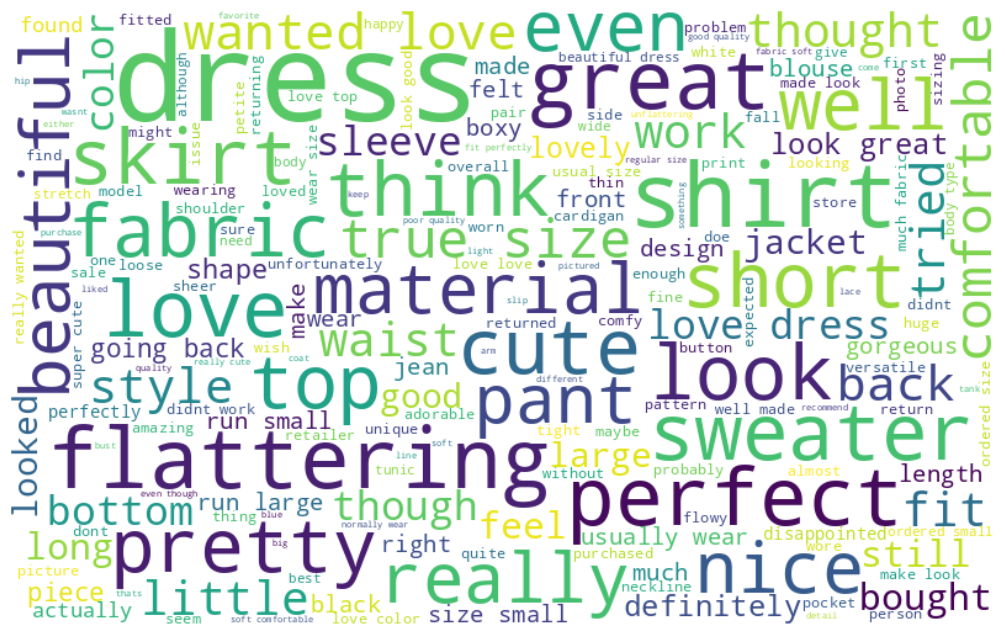

In [ ]:
#Visualizing the Keywords
all_words = " ".join([sentence for sentence in df_upsampled["Cleaned_Review"]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

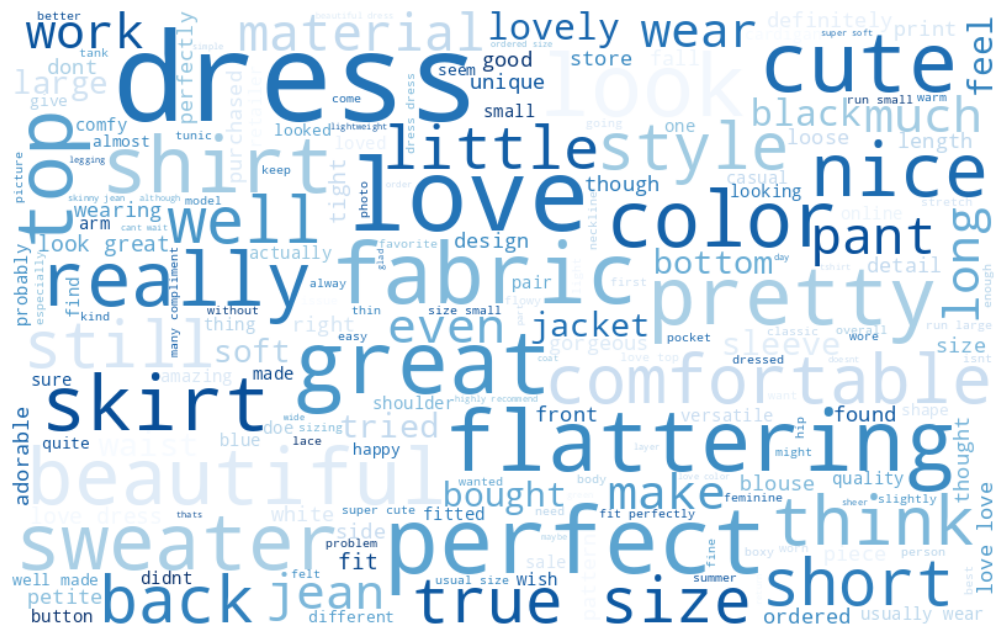

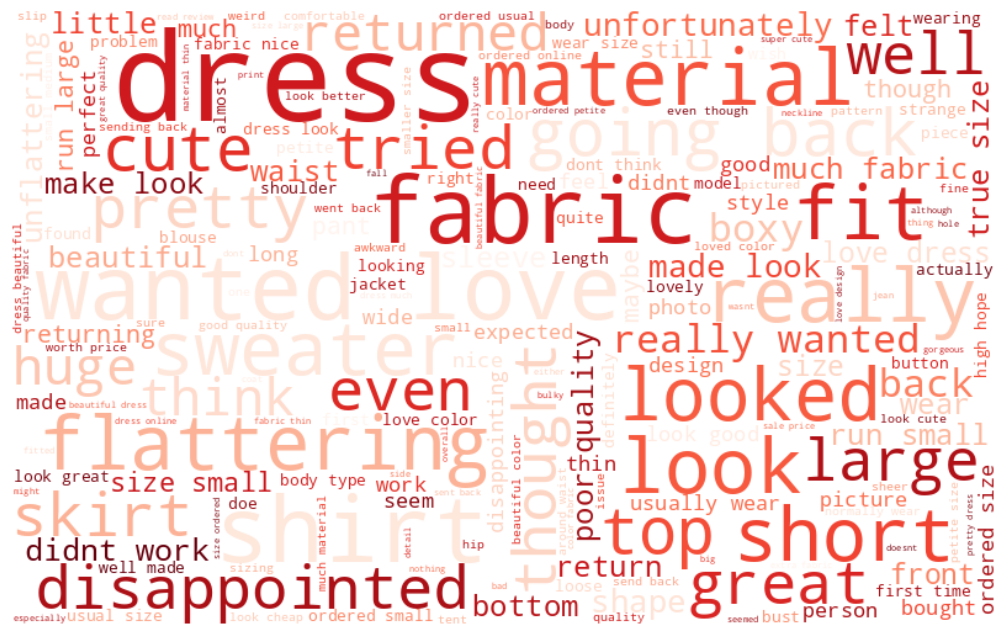

In [ ]:
#Frequent words visualization for Positive Review
all_words = " ".join([sentence for sentence in df_upsampled["Cleaned_Review"][df_upsampled["Recommended"]==1]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', colormap = 'Blues', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

#Frequent words visualization for negative label
all_words = " ".join([sentence for sentence in df_upsampled["Cleaned_Review"][df_upsampled["Recommended"]==0]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', colormap = 'Reds', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### **Splitting data**

In [ ]:
#importing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer #TF-IDF are word frequency scores that try to highlight words that are more interesting

In [ ]:
vectorizer2 = CountVectorizer(ngram_range=(2, 2))

x = df_upsampled["Cleaned_Review"]
y= df_upsampled["Recommended"]

In [ ]:
#train_test splot
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y,random_state=42)

X_train_ngrams = vectorizer2.fit_transform(x_train)
X_test_ngrams = vectorizer2.transform(x_test)


### **Supervised Models**

In [ ]:
accuracy_list = []
f1_list = []
roc_auc_list = []

In [ ]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

In [ ]:
def result(model):

    #fit on data
    model.fit(X_train_ngrams, y_train)

    #prediction
    pred = model.predict(X_test_ngrams)

    #performance of model
    print("Classification Report: \n", classification_report(y_test, pred))
    print("-" * 100)
    print()

    #accuracy of model
    acc = accuracy_score(y_test, pred)
    accuracy_list.append(acc)
    print("Accuracy Score: ", acc)
    print("-" * 100)
    print()

    #f1-score of model
    f1 = f1_score(y_test, pred)
    f1_list.append(f1)
    print("F1 Score: ", f1)
    print("-" * 100)
    print()

    #roc-auc curve of model
    fpr,tpr,threshold = roc_curve(y_test,pred)
    auc_value = auc(fpr,tpr)
    rocauc_score = roc_auc_score(y_test, pred)
    roc_auc_list.append(rocauc_score)
    plt.figure(figsize=(5,5),dpi=100)
    print("ROC-AUC Score: ", f1)
    print("-" * 100)
    print()
    plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print()

    #confusion matrix for model
    print("Confusion Matrix: ")
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');
    plt.title('Confusion Matrix', fontsize=20)

    # Predict the sentiment of a new review using the trained model
    new_review = "i do not love this"
    new_review_features = vectorizer2.transform([new_review])



### **Logistic Regression**

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      3108
           1       0.98      0.95      0.97      3219

    accuracy                           0.97      6327
   macro avg       0.97      0.97      0.97      6327
weighted avg       0.97      0.97      0.97      6327

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9661767030188083
----------------------------------------------------------------------------------------------------

F1 Score:  0.9661392405063292
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.9661392405063292
----------------------------------------------------------------------------------------------------



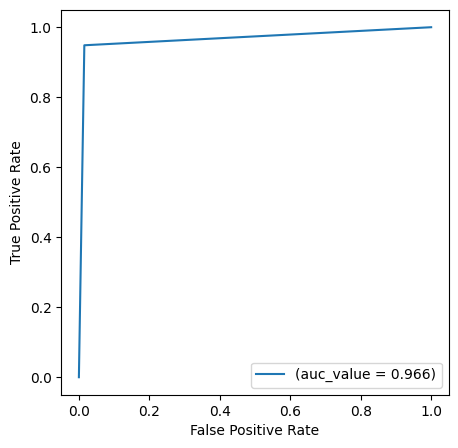


Confusion Matrix: 


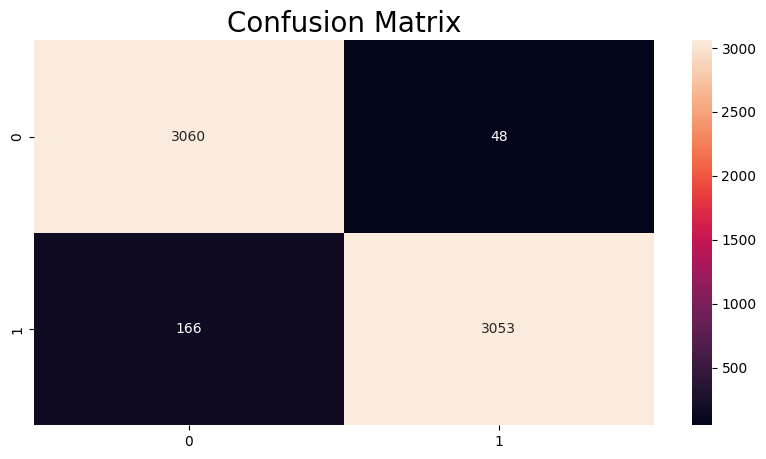

In [ ]:
lr = LogisticRegression()
result(lr)

### **Naive Bayes**

In [ ]:
X = df_upsampled["Cleaned_Review"]
Y= df_upsampled["Recommended"]

In [ ]:
#tokenization

from keras.preprocessing.text import Tokenizer
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)
xtokens= tokenizer.texts_to_sequences(X)

In [ ]:
#padding

from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen=100
xpad=pad_sequences(xtokens,padding='post', maxlen=maxlen)

In [ ]:
#train_test splot
x_train, x_test, y_train, y_test = train_test_split(xpad, Y, test_size=0.2, stratify=y,random_state=42)

In [ ]:
def result(model):

    #fit on data
    model.fit(x_train, y_train)

    #prediction
    pred = model.predict(x_test)

    #performance of model
    print("Classification Report: \n", classification_report(y_test, pred))
    print("-" * 100)
    print()

    #accuracy of model
    acc = accuracy_score(y_test, pred)
    accuracy_list.append(acc)
    print("Accuracy Score: ", acc)
    print("-" * 100)
    print()

    #f1-score of model
    f1 = f1_score(y_test, pred)
    f1_list.append(f1)
    print("F1 Score: ", f1)
    print("-" * 100)
    print()

    #roc-auc curve of model
    fpr,tpr,threshold = roc_curve(y_test,pred)
    auc_value = auc(fpr,tpr)
    rocauc_score = roc_auc_score(y_test, pred)
    roc_auc_list.append(rocauc_score)
    plt.figure(figsize=(5,5),dpi=100)
    print("ROC-AUC Score: ", f1)
    print("-" * 100)
    print()
    plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print()

    #confusion matrix for model
    print("Confusion Matrix: ")
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');
    plt.title('Confusion Matrix', fontsize=20)



Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.99      0.66      3108
           1       0.78      0.03      0.06      3219

    accuracy                           0.50      6327
   macro avg       0.64      0.51      0.36      6327
weighted avg       0.64      0.50      0.35      6327

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.5021337126600285
----------------------------------------------------------------------------------------------------

F1 Score:  0.05801435406698565
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.05801435406698565
----------------------------------------------------------------------------------------------------



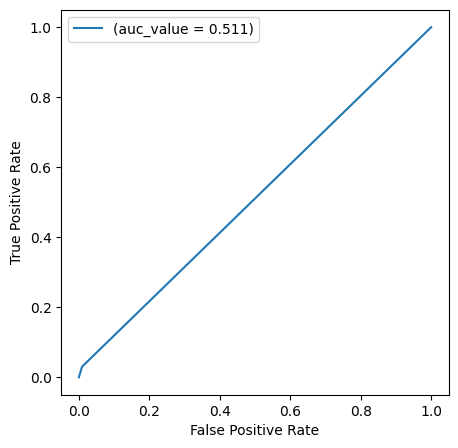


Confusion Matrix: 


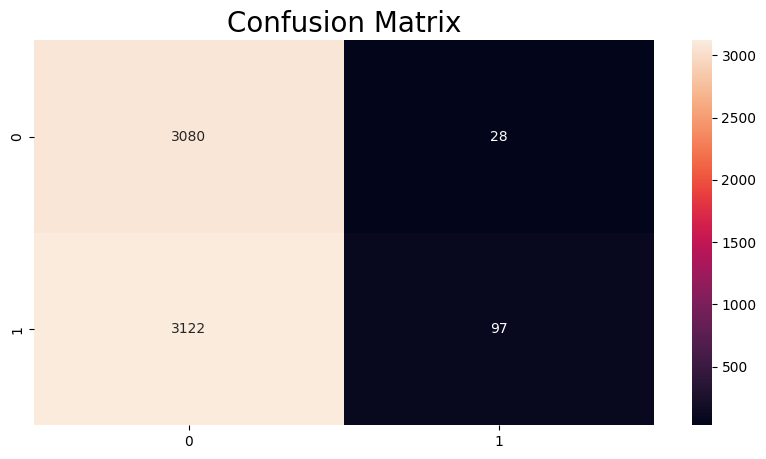

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
result(nb)

In [ ]:
from nltk.corpus.reader import reviews
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression


# Split the dataset into training and testing sets
x = df_upsampled["Cleaned_Review"]
y = df_upsampled["Recommended"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y,random_state=42)

# Create bi-gram vectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform training data using vectorizer
X_train_vec = vectorizer.fit_transform(x_train)


# Convert the text data into numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(x_train)
test_features = vectorizer.transform(x_test)

# Train a logistic regression model on the training set
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Predict the sentiment of the test set using the trained model
predictions = model.predict(test_features)

# Print the accuracy of the model on the test set
accuracy = (predictions == y_test).mean()
print('Accuracy:', accuracy)

# Predict the sentiment of a new review using the trained model
new_review = "i liked the color but it did not work for me"
new_review_features = vectorizer.transform([new_review])
prediction = model.predict(new_review_features)[0]
if prediction == 1:
    print('Positive review')
else:
    print('Negative review')



Accuracy: 0.9315631420894579
Negative review


## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import numpy as np
import graphviz

Accuracy: 0.8971076339497392

Accuracy Score on train data:  0.9998419472103682
Accuracy Score on test data:  0.8971076339497392

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      3108
           1       0.99      0.81      0.89      3219

    accuracy                           0.90      6327
   macro avg       0.91      0.90      0.90      6327
weighted avg       0.91      0.90      0.90      6327

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.8971076339497392
----------------------------------------------------------------------------------------------------

F1 Score:  0.8889646938427426
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.8889646938427426
----------------------------------------------------------------------------------------------------



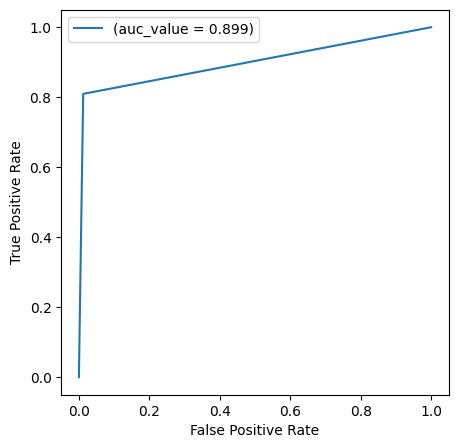


Confusion Matrix: 


Text(0.5, 1.0, 'Confusion Matrix')

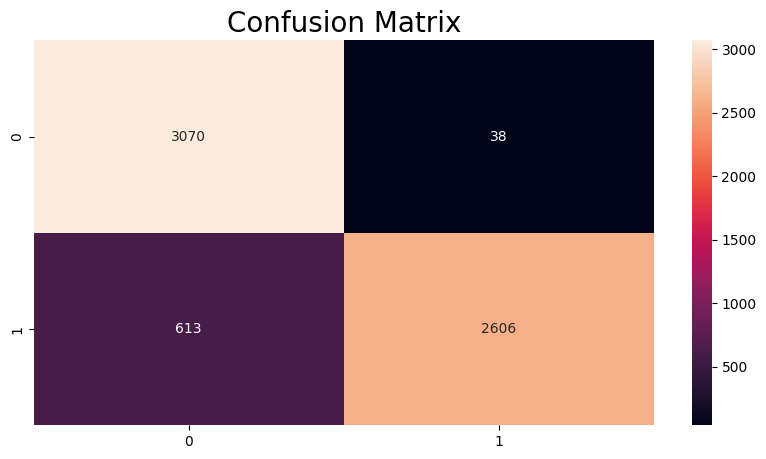

In [ ]:
#Create a decision tree classifier and fit it to the training data:

clf = DecisionTreeClassifier()
clf.fit(X_train_ngrams, y_train)

pred_tree = clf.predict(X_test_ngrams)
#Evaluate the performance of the model on the testing data:

accuracy = clf.score(X_test_ngrams, y_test)

print("Accuracy:", accuracy)
print()
# to tuning
y_train_pred = clf.predict(X_train_ngrams)
y_test_pred = clf.predict(X_test_ngrams)

#Use accuracy metric from sklearn.metrics library
print('Accuracy Score on train data: ', metrics.accuracy_score(y_train, y_train_pred))
print('Accuracy Score on test data: ', metrics.accuracy_score(y_test, y_test_pred))
print()

#performance of model
print("Classification Report: \n", classification_report(y_test, pred_tree))
print("-" * 100)
print()

#accuracy of model
acc = accuracy_score(y_test, pred_tree)
accuracy_list.append(acc)
print("Accuracy Score: ", acc)
print("-" * 100)
print()

#f1-score of model
f1 = f1_score(y_test, pred_tree)
f1_list.append(f1)
print("F1 Score: ", f1)
print("-" * 100)
print()

#roc-auc curve of model
fpr,tpr,threshold = roc_curve(y_test,pred_tree)
auc_value = auc(fpr,tpr)
rocauc_score = roc_auc_score(y_test, pred_tree)
roc_auc_list.append(rocauc_score)
plt.figure(figsize=(5,5),dpi=100)
print("ROC-AUC Score: ", f1)
print("-" * 100)
print()
plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print()

#confusion matrix for model
print("Confusion Matrix: ")
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, pred_tree), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20)


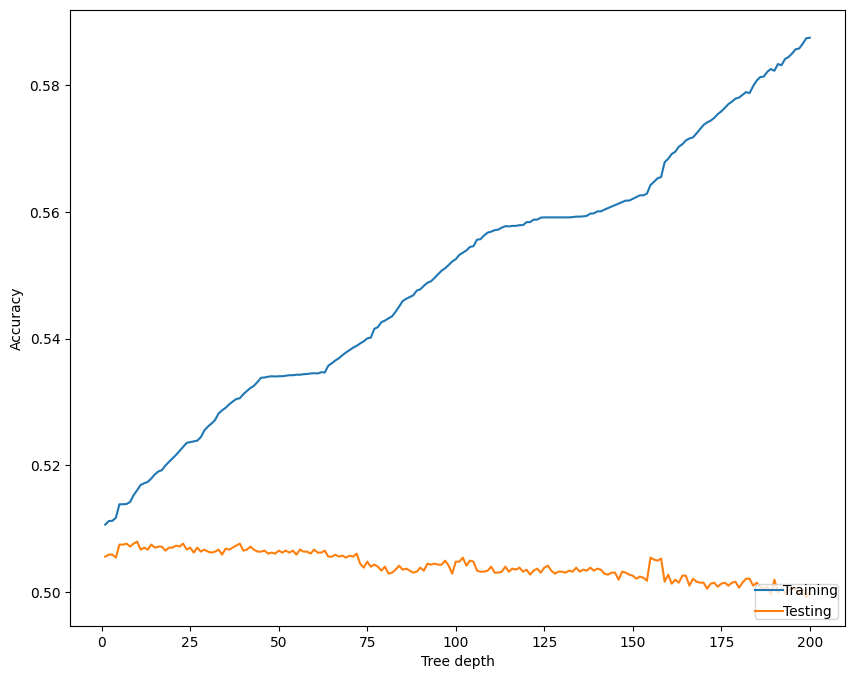

In [ ]:
max_depth = np.linspace(1,200,200,dtype='int32')
accuracy_train,accuracy_test=[],[]

for i in max_depth:
    clf_dt=tree.DecisionTreeClassifier(max_depth=i, random_state=40)
    clf_dt.fit(X_train_ngrams,y_train)
    y_train_pred = clf_dt.predict(X_train_ngrams)
    y_test_pred = clf_dt.predict(X_test_ngrams)

    accuracy_train.append(metrics.accuracy_score(y_train, y_train_pred))
    accuracy_test.append(metrics.accuracy_score(y_test, y_test_pred))

ax= plt.figure(figsize=(10, 8))
plt.plot(max_depth,accuracy_train)
plt.plot(max_depth,accuracy_test)
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.legend(['Training', 'Testing'],loc='lower right', borderpad=0, handletextpad=0)
plt.show()

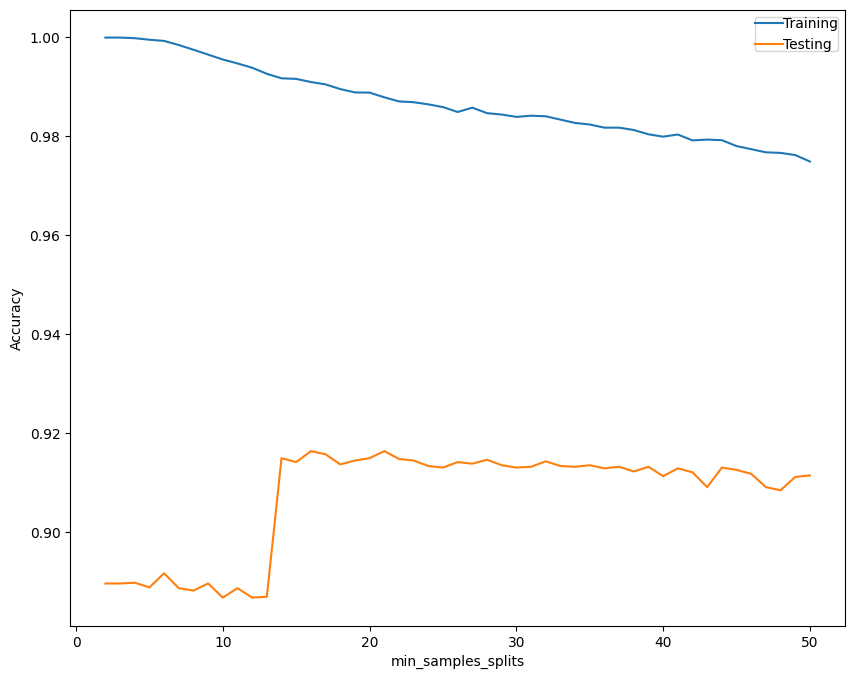

In [ ]:
min_samples_split = np.linspace(2, 50, 50,dtype='int32')
accuracy_train,accuracy_test=[],[]

for i in min_samples_split:
    clf_dt=tree.DecisionTreeClassifier(min_samples_split=i, random_state=40)
    clf_dt.fit(X_train_ngrams,y_train)
    y_train_pred = clf_dt.predict(X_train_ngrams)
    y_test_pred = clf_dt.predict(X_test_ngrams)

    accuracy_train.append(metrics.accuracy_score(y_train, y_train_pred))
    accuracy_test.append(metrics.accuracy_score(y_test, y_test_pred))

ax= plt.figure(figsize=(10, 8))
plt.plot(min_samples_split,accuracy_train)
plt.plot(min_samples_split,accuracy_test)
plt.ylabel('Accuracy')
plt.xlabel('min_samples_splits')
plt.legend(['Training', 'Testing'],loc='upper right', borderpad=0, handletextpad=0)
plt.show()

In [ ]:
Tuned_tree = tree.DecisionTreeClassifier(random_state=40,max_depth=150, min_samples_split=50)
Tuned_tree.fit(X_train_ngrams,y_train)
y_train_pred = Tuned_tree.predict(X_train_ngrams)
y_test_pred = Tuned_tree.predict(X_test_ngrams)

#Use accuracy metric from sklearn.metrics library
print('Accuracy Score on train data: ', metrics.accuracy_score(y_train, y_train_pred))
print('Accuracy Score on test data: ', metrics.accuracy_score(y_test, y_test_pred))

Accuracy Score on train data:  0.5551604235814762
Accuracy Score on test data:  0.5029239766081871


AttributeError: ignored

<Figure size 640x480 with 0 Axes>

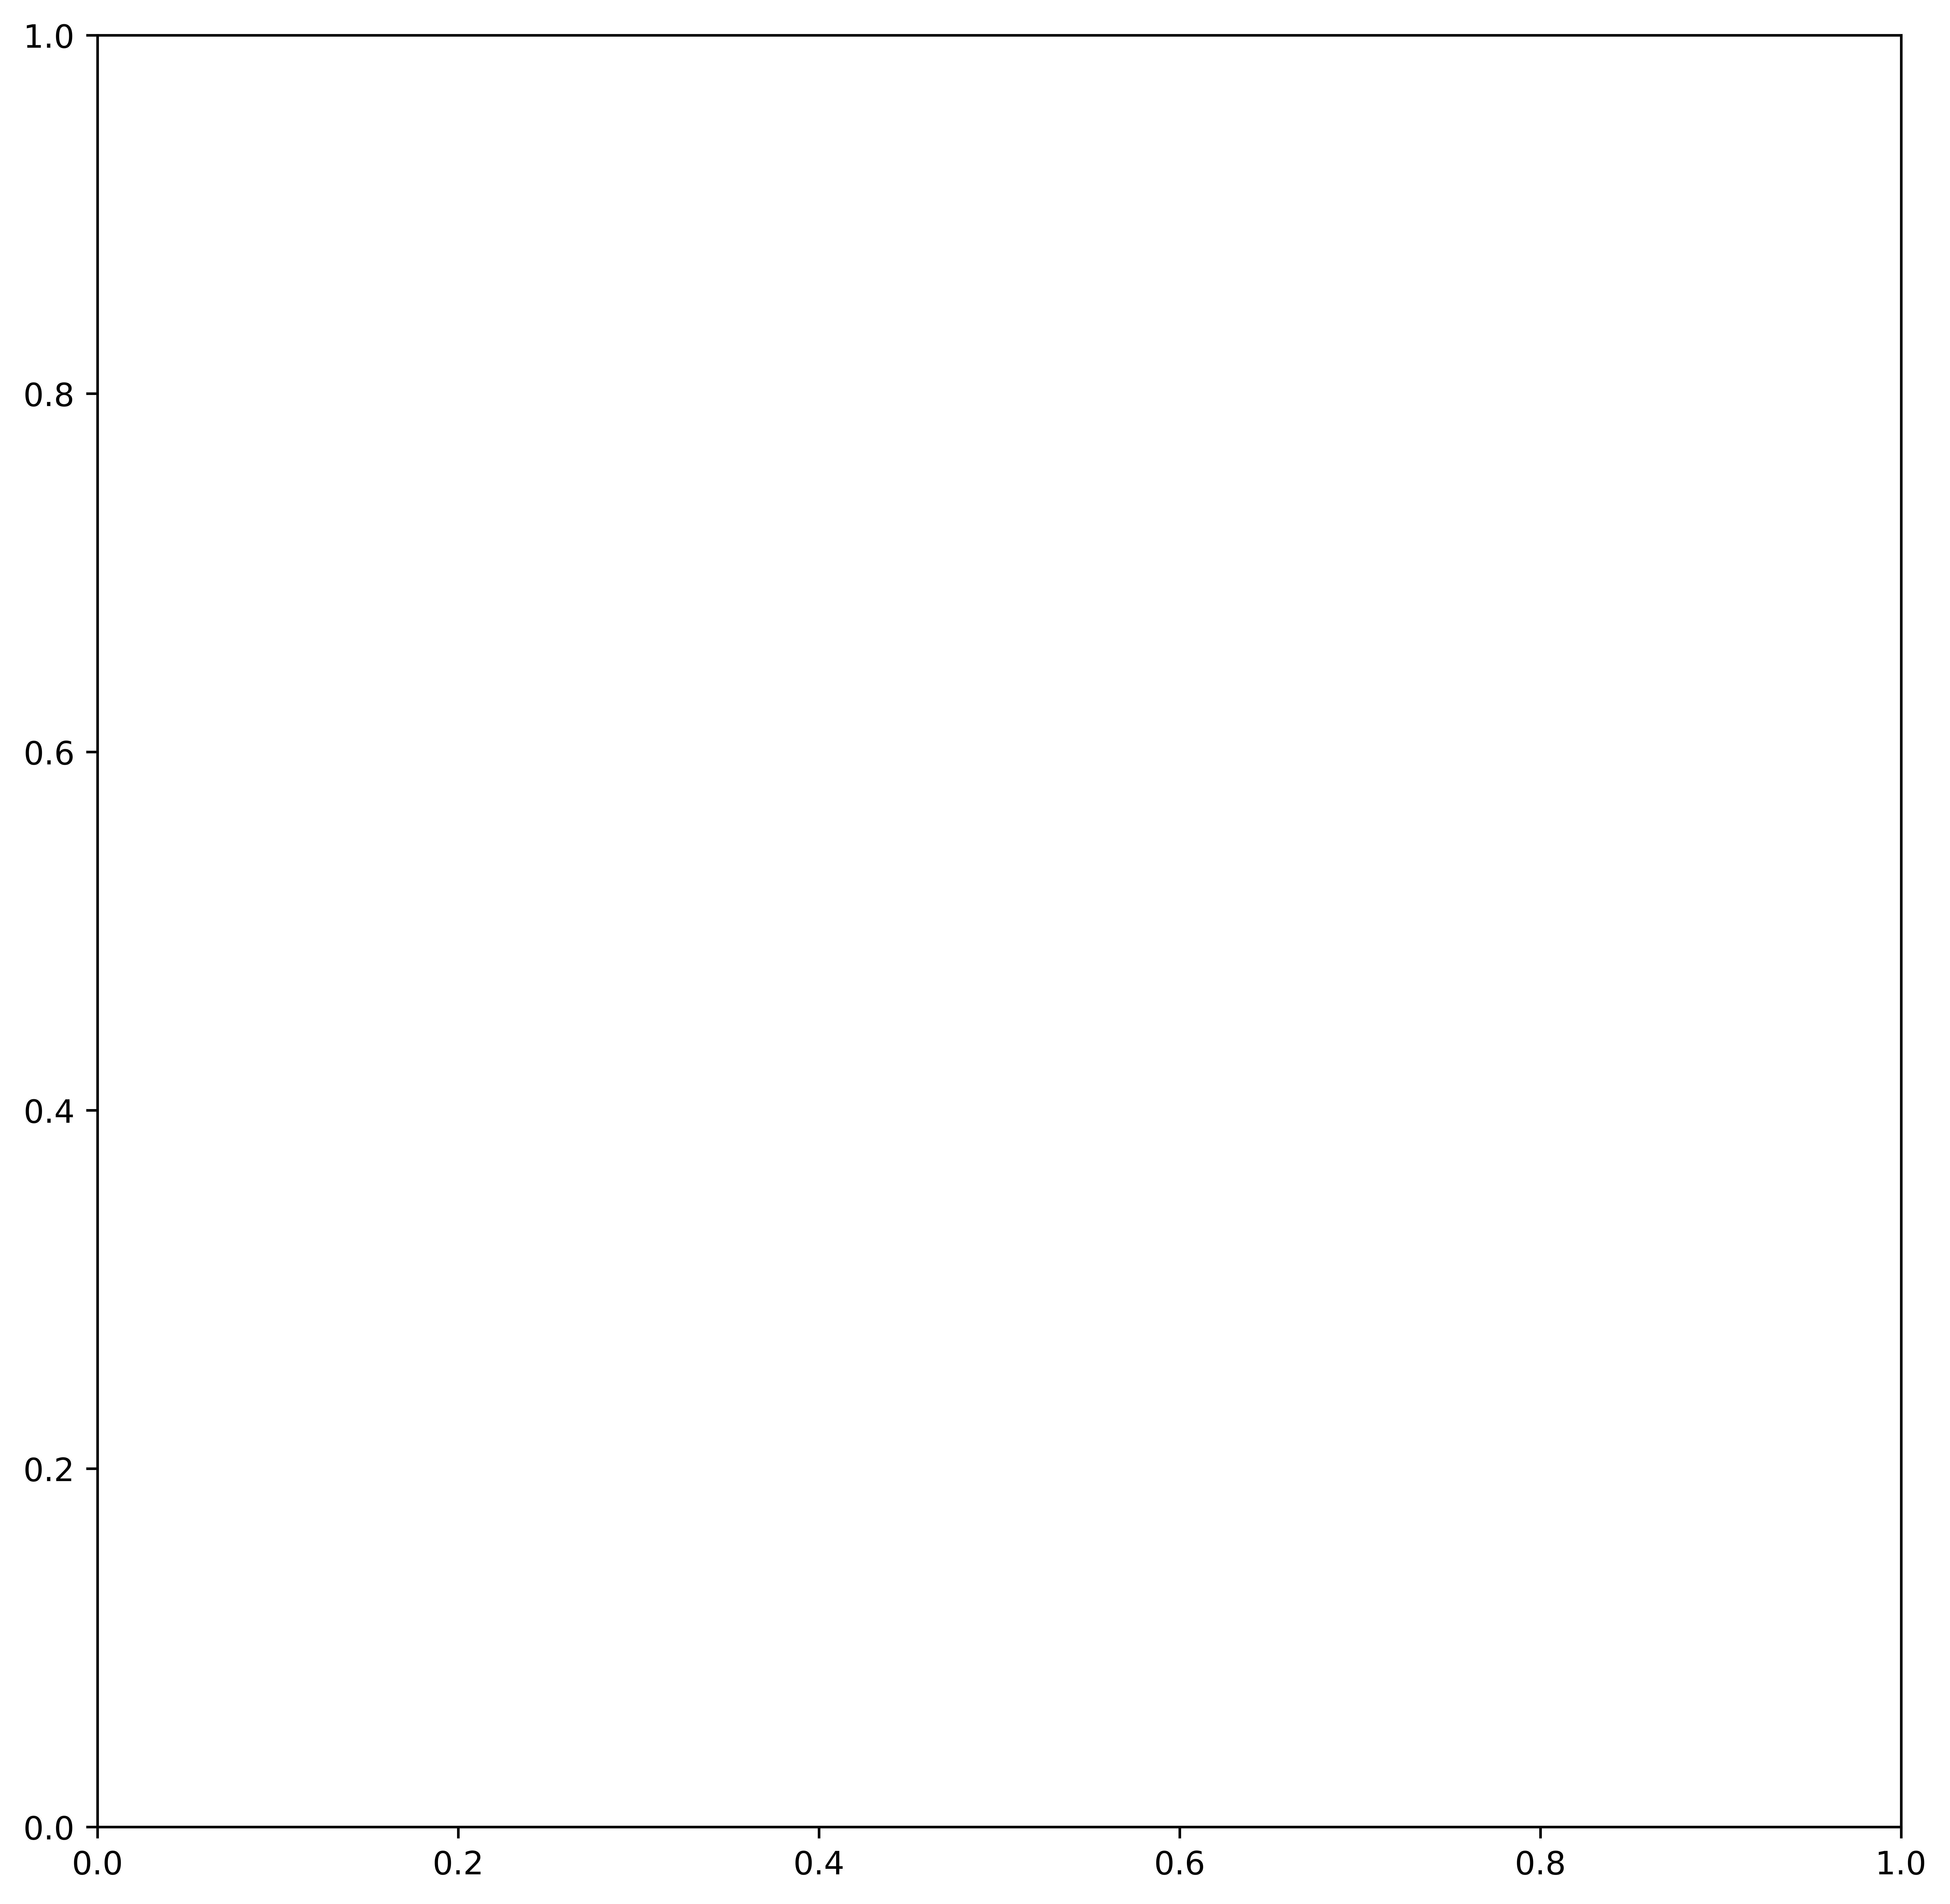

In [ ]:
# Visualize decision tree using graphviz
col = df_upsampled["Recommended"]
plt.figure()
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=800)
tree.plot_tree(Tuned_tree, feature_names = X.Recommended.tolist(),
               class_names=['Negative', 'Positive'],
               filled = True,
              rounded=True)
plt.show()

## **SVC**

Accuracy: 0.9291923502449818

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      3133
           1       0.96      0.90      0.93      3194

    accuracy                           0.93      6327
   macro avg       0.93      0.93      0.93      6327
weighted avg       0.93      0.93      0.93      6327

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9291923502449818
----------------------------------------------------------------------------------------------------

F1 Score:  0.927741935483871
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.927741935483871
----------------------------------------------------------------------------------------------------



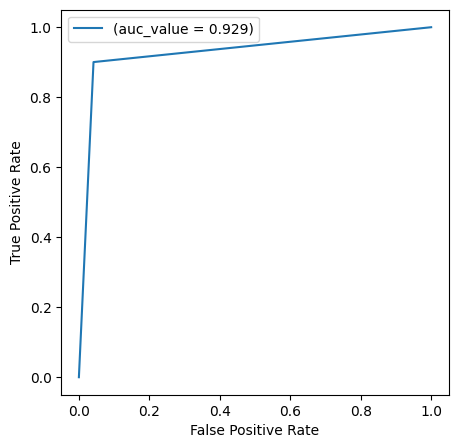


Confusion Matrix: 


Text(0.5, 1.0, 'Confusion Matrix')

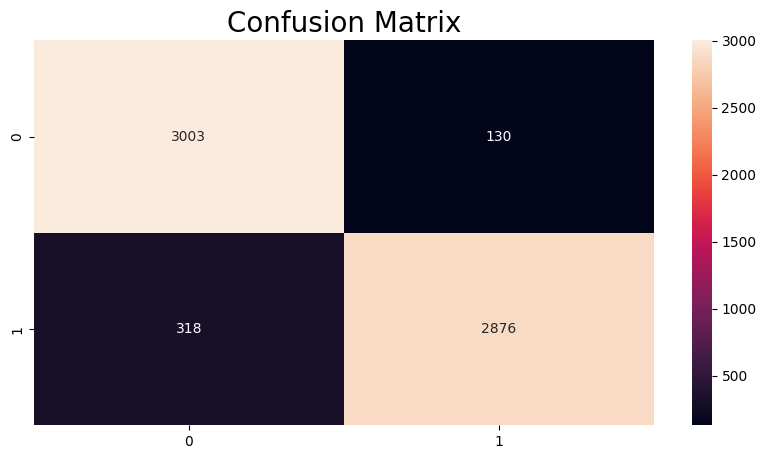

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Convert the text data into numerical features using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_SVC = vectorizer.fit_transform(df_upsampled['Cleaned_Review'])
Y_SVC = df_upsampled['Recommended']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_SVC, Y_SVC, test_size=0.2)


# Train the SVM model on the training set
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred_SVC = svm_model.predict(X_test)

# Evaluate the accuracy of the model on the testing set
accuracy = accuracy_score(y_test, y_pred_SVC)
print('Accuracy:', accuracy)
print()

#performance of model
print("Classification Report: \n", classification_report(y_test, y_pred_SVC))
print("-" * 100)
print()

#accuracy of model
acc = accuracy_score(y_test, y_pred_SVC)
accuracy_list.append(acc)
print("Accuracy Score: ", acc)
print("-" * 100)
print()

#f1-score of model
f1 = f1_score(y_test, y_pred_SVC)
f1_list.append(f1)
print("F1 Score: ", f1)
print("-" * 100)
print()

#roc-auc curve of model
fpr,tpr,threshold = roc_curve(y_test,y_pred_SVC)
auc_value = auc(fpr,tpr)
rocauc_score = roc_auc_score(y_test, y_pred_SVC)
roc_auc_list.append(rocauc_score)
plt.figure(figsize=(5,5),dpi=100)
print("ROC-AUC Score: ", f1)
print("-" * 100)
print()
plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print()

#confusion matrix for model
print("Confusion Matrix: ")
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_SVC), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20)
